## Adaptive RAG

This notebook implements Adaptive RAG with intelligent query routing:

Three routing paths:
1. **Financial Documents (vectorstore)** -> Self-RAG flow (retrieve -> grade -> generate -> check hallucinations -> check answer quality)
2. **Employee Database (sql_database)** -> SQL agent -> query execution -> generate
3. **General Knowledge (web_search)** -> Web search -> generate

Query Analysis determines which path to take based on query intent.

In [1]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
import os

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_chroma import Chroma
from langchain_community.utilities import SQLDatabase
from pydantic import BaseModel, Field

from scripts import my_tools, mysql_tools
from scripts.nodes import (
    retrieve_node,
    grade_documents_node,
    generate_node,
    transform_query_node,
    should_generate,
    check_answer_quality,
    get_latest_user_query
)

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================
LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

# https://github.com/fracpete/employees-db-sqlite
SQL_DB_PATH = "sqlite:///db/employees_db-full-1.0.6.db"


In [3]:
# SQL database for employees
sql_db = SQLDatabase.from_uri(SQL_DB_PATH)
sql_schema = sql_db.get_table_info()
mysql_tools.init_sql_env(sql_db, llm, sql_schema)
print(f"[SQL DB] Connected to employees database")
print(f"[SQL DB] Tables: {', '.join(sql_db.get_usable_table_names())}")


Initialized SQL environment
[SQL DB] Connected to employees database
[SQL DB] Tables: departments, dept_emp, dept_manager, employees, salaries, titles


In [4]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================

class RouteQuery(BaseModel):
    """Route query to appropriate datasource"""
    datasource: str = Field(description="Datasource to route query to: 'retrieve' for financial documents, 'sql_agent' for employee information, 'web_search' for general knowledge")

In [5]:
# =============================================================================
# State
# =============================================================================

class AgentState(TypedDict):
    """State for Adaptive RAG system"""
    messages: Annotated[List, operator.add]
    retrieved_docs: str
    sql_results: str
    web_results: str
    rewritten_queries: List[str]

In [6]:
# -----------------------------------------------------------------------------
# Query Analysis & Routing
# -----------------------------------------------------------------------------

# Route query to appropriate datasource
def route_question(state:AgentState):
    print("[ROUTE] Analyzing query")
    
    query = get_latest_user_query(state['messages'])
    print(f"[QUERY] {query}")
    
    # Create structured output LLM for routing
    llm_router = llm.with_structured_output(RouteQuery)
    
    system_prompt = """You are an expert at routing user questions to the appropriate datasource.

**Datasources:**
1. **retrieve**: Financial documents (10-K, 10-Q, 8-K reports) about companies like Amazon, Apple, Google
   - Questions about: revenue, operating income, cash flow, segments, financial metrics, quarterly/annual performance
   - Examples: "What was Amazon's revenue in 2023?", "Compare Apple vs Google Q1 2024 revenue"

2. **sql_agent**: Employee database with structured data
   - Questions about: employees, departments, salaries, managers, job titles, hiring dates
   - Examples: "Who is the CFO?", "List employees in Finance", "What is John's salary?"

3. **web_search**: General knowledge outside our databases
   - Questions about: current events, general facts, topics unrelated to our data
   - Examples: "What is inflation rate?", "How does RAG work?", "Capital of France?"

**Decision Logic:**
- Check for financial terms (revenue, income, cash flow, quarterly, annual, 10-K, 10-Q) -> retrieve
- Check for company names in our database (amazon, apple, google) -> retrieve
- Check for employee-related terms (employee, department, salary, CFO, manager) -> sql_agent
- Everything else -> web_search

Return the datasource field only."""
    
    message = HumanMessage(f"Route this query: {query}")
    messages = [SystemMessage(system_prompt), message]
    response = llm_router.invoke(messages)
    datasource = response.datasource
    
    print(f"[DECISION] Routing to {datasource}")
    
    return datasource

In [7]:
# -----------------------------------------------------------------------------
# SQL Database Path (Agent-based)
# -----------------------------------------------------------------------------

# Query employee database using SQL tools
def sql_agent_node(state:AgentState):
    print("[SQL] Querying employee database")
    
    query = get_latest_user_query(state['messages'])
    
    # Bind SQL tools to LLM
    llm_with_tools = llm.bind_tools(mysql_tools.ALL_SQL_TOOLS)
    
    system_prompt = f"""You are a SQL expert assistant with access to an employee database.

Your task: Answer the user's question by querying the database.

**Workflow:**
1. Use get_database_schema() to understand table structure
2. Use generate_sql_query() to create SQL from natural language
3. Use validate_sql_query() to check safety
4. Use execute_sql_query() to run the query
5. If error occurs, use fix_sql_error() to correct it

**Important:**
- Always validate queries before execution
- Only use SELECT statements
- Provide clear, formatted results

User query: {query}"""
    
    message = HumanMessage(query)
    messages = [SystemMessage(system_prompt), message]
    response = llm_with_tools.invoke(messages)
    
    print(f"[SQL] Response generated")
    
    return {'messages': [response]}

In [8]:
# -----------------------------------------------------------------------------
# Web Search Path
# -----------------------------------------------------------------------------

# Search the web for general knowledge
def web_search_node(state:AgentState):
    print("[WEB] Searching the web")
    
    query = get_latest_user_query(state['messages'])
    
    # Use web_search tool from my_tools
    result = my_tools.web_search.invoke({'query': query, 'num_results': 5})
    
    print(f"[WEB] Retrieved {len(result)} characters")
    
    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/adaptive_rag_web_results.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(result)
    
    return {'web_results': result}

In [9]:
# -----------------------------------------------------------------------------
# Generate Nodes
# -----------------------------------------------------------------------------

# Generate answer based on SQL query results
def generate_from_sql_node(state:AgentState):
    print("[GENERATE] Creating answer from SQL results")
    
    query = get_latest_user_query(state['messages'])
    
    # Get SQL results from messages (last AI message should contain tool responses)
    sql_results = state.get('sql_results', '')
    if not sql_results:
        # Try to extract from messages if available
        for msg in reversed(state['messages']):
            if hasattr(msg, 'content') and msg.content:
                sql_results = msg.content
                break
    
    system_prompt = """You are a helpful assistant providing clear answers based on database query results.

**OUTPUT FORMAT:**
Write a clear, concise answer in **MARKDOWN** format:
- Use ## headings if organizing complex data
- Use tables for structured data
- Use bullet points for lists
- Be direct and factual

**GUIDELINES:**
- Base your answer on the SQL query results provided
- Format data clearly (use tables, lists)
- If no results found, say so clearly
- Don't add information not in the results"""
    
    message = HumanMessage(f"SQL Query Results:\n\n{sql_results}\n\nQuery: {query}")
    messages = [SystemMessage(system_prompt), message]
    response = llm.invoke(messages)
    
    print(f"[GENERATED] Answer created ({len(response.content)} chars)")
    
    # Save for debugging
    with open("debug_logs/adaptive_rag_sql_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(response.content)
    
    return {'messages': [response]}

In [10]:
# Generate answer based on web search results
def generate_from_web_node(state:AgentState):
    print("[GENERATE] Creating answer from web search")
    
    query = get_latest_user_query(state['messages'])
    web_results = state.get('web_results', '')
    
    system_prompt = """You are a helpful assistant providing clear answers based on web search results.

**OUTPUT FORMAT:**
Write a clear answer (150-250 words) in **MARKDOWN** format:
- Use ## headings for sections
- Use **bold** for emphasis
- Use bullet points for key facts
- Be informative and accurate

**GUIDELINES:**
- Base your answer on the web search results provided
- Synthesize information from multiple sources
- Be factual and objective
- If results are insufficient, acknowledge it"""
    
    message = HumanMessage(f"Web Search Results:\n\n{web_results}\n\nQuery: {query}")
    messages = [SystemMessage(system_prompt), message]
    response = llm.invoke(messages)
    
    print(f"[GENERATED] Answer created ({len(response.content)} chars)")
    
    # Save for debugging
    with open("debug_logs/adaptive_rag_web_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(response.content)
    
    return {'messages': [response]}

[GRAPH] Building Adaptive RAG workflow


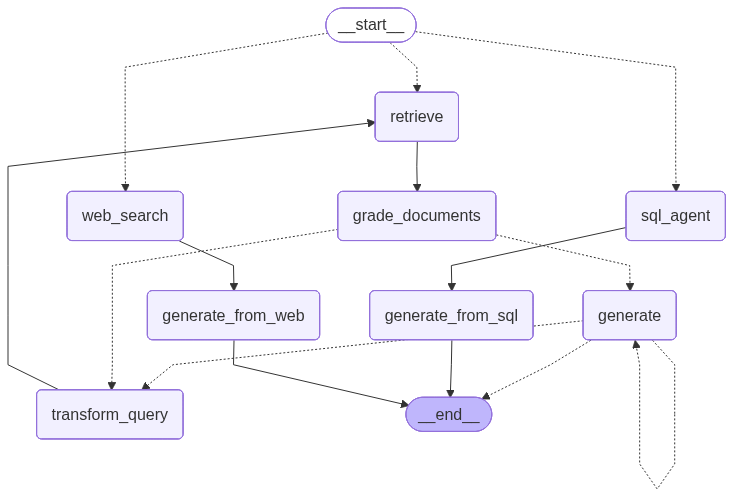

In [11]:
# =============================================================================
# Build Graph
# =============================================================================

# Build Adaptive RAG graph with three routing paths
def create_adaptive_rag():
    print("[GRAPH] Building Adaptive RAG workflow")
    
    builder = StateGraph(AgentState)
    
    # Add Self-RAG nodes (imported from scripts.nodes)
    builder.add_node('retrieve', retrieve_node)
    builder.add_node('grade_documents', grade_documents_node)
    builder.add_node('generate', generate_node)
    builder.add_node('transform_query', transform_query_node)
    
    # Add Adaptive-specific nodes
    builder.add_node('sql_agent', sql_agent_node)
    builder.add_node('web_search', web_search_node)
    builder.add_node('generate_from_sql', generate_from_sql_node)
    builder.add_node('generate_from_web', generate_from_web_node)
    
    # Entry point: Route query to appropriate datasource
    builder.add_conditional_edges(START, route_question, ['retrieve', 'sql_agent', 'web_search'])
    
    # Vector store path (Self-RAG flow)
    builder.add_edge('retrieve', 'grade_documents')
    builder.add_conditional_edges('grade_documents', should_generate, ['transform_query', 'generate'])
    builder.add_edge('transform_query', 'retrieve')
    builder.add_conditional_edges('generate', check_answer_quality, ['generate', END, 'transform_query'])
    
    # SQL database path
    builder.add_edge('sql_agent', 'generate_from_sql')
    builder.add_edge('generate_from_sql', END)
    
    # Web search path
    builder.add_edge('web_search', 'generate_from_web')
    builder.add_edge('generate_from_web', END)
    
    return builder.compile()

graph = create_adaptive_rag()

graph

In [12]:
result = graph.invoke({'messages': [HumanMessage("What was Amazon's revenue in 2023?")]})
print(result['messages'][-1].content)

[ROUTE] Analyzing query
[QUERY] What was Amazon's revenue in 2023?
[DECISION] Routing to retrieve
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
   [1] Doc 18: score=23.4068
   [2] Doc 2: score=22.7389
   [3] Doc 10: score=20.1882
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  yes
[ROUTER] Assess graded documents
[ROUTER] Have relevant documents - generating answer
[GENERATE] Creating Answer
[ROUTER] Generation is gounded in documents
[ROUTER] Checking answer quality
[ROUTER] generation is good. - USEFUL
## Amazon's 2023 Revenue

Amazon's total revenue for 2023, referred to as **net sales** in the 10-K filing, was **$574.785 billion** (or **$574,785 million**). This figure is derived from the consolidated segment breakdown, which aggregates revenue from North America, International, and AWS (Amazon Web Services) [2]. 

### Key Breakdown of 

In [13]:
result = graph.invoke({'messages': [HumanMessage("What is the current inflation rate across the globe?")]})
print(result['messages'][-1].content)

[ROUTE] Analyzing query
[QUERY] What is the current inflation rate across the globe?
[DECISION] Routing to web_search
[WEB] Searching the web
[WEB] Retrieved 8559 characters
[GENERATE] Creating answer from web search
[GENERATED] Answer created (1954 chars)
## Current Global Inflation Rate: A 2025 Overview  

As of November 2025, the **global inflation rate** remains a critical economic indicator, with data sourced from organizations like the IMF, World Bank, and national statistical offices. While specific 2025 figures are still being updated, recent trends and 2024 data provide context:  

### Key Global Inflation Trends (2024 Data)  
- **Global Average**: 5.8% year-over-year (2024).  
- **United States**: 3.0% (CPI-based).  
- **European Union**: 2.6% (HICP-based).  
- **Developing Nations**: Higher rates in regions like Latin America and Africa, with some countries experiencing double-digit inflation.  

### Notable High-Inflation Countries  
- **Venezuela**: Over **1 million%** inf

In [14]:
result = graph.invoke({'messages': [HumanMessage("List top 5 highest paid employees in the Finance department")]})
print(result['messages'][-1].content)

[ROUTE] Analyzing query
[QUERY] List top 5 highest paid employees in the Finance department
[DECISION] Routing to sql_agent
[SQL] Querying employee database
[SQL] Response generated
[GENERATE] Creating answer from SQL results
[GENERATED] Answer created (414 chars)
## No Results Found

The query to list the top 5 highest-paid employees in the Finance department returned no results. This could indicate:
- No employees are assigned to the Finance department
- No salary data exists for employees in this department
- The query might need refinement (e.g., filtering criteria, department name spelling)

Please verify the data source or adjust the query parameters and try again.


In [15]:
result = graph.invoke({'messages': [HumanMessage("Compare Apple and Amazon revenue in Q1 2024")]})
print(result['messages'][-1].content)

[ROUTE] Analyzing query
[QUERY] Compare Apple and Amazon revenue in Q1 2024
[DECISION] Routing to retrieve
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: Compare Apple and Amazon revenue in Q1 2024

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Amazon revenue in Q1 2024
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  no
[ROUTER] Assess graded documents
[ROUTER] No relevant documents - transforming query
New Search Queries: ['Apple total revenue Q1 2024', 'Amazon total revenue Q1 2024']
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: Apple total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Apple total revenue Q1 2024
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[RETRIEVE] Query 2: Amazon total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Amazon total revenue Q1 2024
   [1] D